In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import datetime, nltk, warnings
import matplotlib.cm as cm
import itertools
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import preprocessing, model_selection, metrics, feature_selection
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn import neighbors, linear_model, svm, tree, ensemble
from sklearn.ensemble import AdaBoostClassifier
from sklearn.decomposition import PCA
from IPython.display import display, HTML
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode,iplot

In [2]:


df = pd.read_excel('sample_data_test.xlsx',  
                dtype ={'product': str,'cid_no': int,'channel_id': str, 'income': int})
df.head()
pd.DataFrame(df.dtypes).T.rename(index={0:'column type'})


,cid_no,channel_id,transaction_id,transaction_datetime,transaction_amount,product,service_category,transaction_location,transaction_type,customer_type,sex,date_of_birth,educational_status,income,minor,marital_status,dependents
column type,object,object,object,datetime64[ns],float64,float64,object,int64,object,object,object,object,object,object,object,object,int64


In [3]:
df.rename(columns=lambda x:x.strip(), inplace=True)
df.describe()

,transaction_amount,product,transaction_location,dependents
count,2.653000e+03,0.0,2653.000000,2653.000000
mean,7.060409e+05,NaN,38.240482,0.386355
std,1.425588e+06,NaN,28.535896,1.169462
min,3.100000e+01,NaN,2.000000,0.000000
25%,2.620000e+05,NaN,14.000000,0.000000
50%,3.670000e+05,NaN,26.000000,0.000000
75%,6.500000e+05,NaN,63.000000,0.000000
max,3.500000e+07,NaN,91.000000,12.000000


In [4]:
print('Dataframe dimensions:', df.shape)    
# gives some infos on columns types and numer of null values
tab_info=pd.DataFrame(df.dtypes).T.rename(index={0:'column type'})
tab_info=tab_info.append(pd.DataFrame(df.isnull().sum()).T.rename(index={0:'null values (nb)'}))
tab_info=tab_info.append(pd.DataFrame(df.isnull().sum()/df.shape[0]*100).T.
                         rename(index={0:'null values (%)'}))
display(tab_info)


Dataframe dimensions: (2653, 17)


,cid_no,channel_id,transaction_id,transaction_datetime,transaction_amount,product,service_category,transaction_location,transaction_type,customer_type,sex,date_of_birth,educational_status,income,minor,marital_status,dependents
column type,object,object,object,datetime64[ns],float64,float64,object,int64,object,object,object,object,object,object,object,object,int64
null values (nb),0,0,0,0,0,2653,0,0,0,0,1837,1875,1943,2016,1027,1925,0
null values (%),0,0,0,0,0,100,0,0,0,0,69.2424,70.6747,73.2378,75.9894,38.7109,72.5594,0


In [5]:
#deleting columns having missing values more than 25% as they will not give much value and all transcation types are same hence not of any use
#del df['sex','date_of_birth','educational_status','income','minor','marital_status','product','transaction_type','product']

df = df.drop(df.columns[[10, 12, 13, 14, 15, 11, 5,6]], axis=1) 


# gives some infos on columns types and numer of null values
tab_info=pd.DataFrame(df.dtypes).T.rename(index={0:'column type'})
tab_info=tab_info.append(pd.DataFrame(df.isnull().sum()).T.rename(index={0:'null values (nb)'}))
tab_info=tab_info.append(pd.DataFrame(df.isnull().sum()/df.shape[0]*100).T.
                         rename(index={0:'null values (%)'}))
display(tab_info)

,cid_no,channel_id,transaction_id,transaction_datetime,transaction_amount,transaction_location,transaction_type,customer_type,dependents
column type,object,object,object,datetime64[ns],float64,int64,object,object,int64
null values (nb),0,0,0,0,0,0,0,0,0
null values (%),0,0,0,0,0,0,0,0,0


Now we have a dataset which have no missing values. Finally, I check for duplicate entries and delete them:

In [6]:
print('Entrées dupliquées: {}'.format(df.duplicated().sum()))
df.drop_duplicates(inplace = True)

Entrées dupliquées: 105


The column transacion_amount has highly skewed data hence using log of this column will help

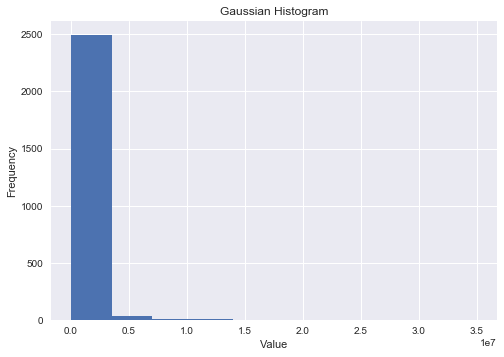

In [7]:
plt.hist(df['transaction_amount'])
plt.title("Gaussian Histogram")
plt.xlabel("Value")
plt.ylabel("Frequency")                                

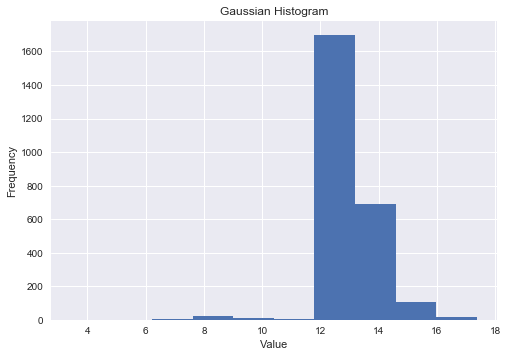

In [8]:
df1= df['transaction_amount'].apply(np.log)
plt.hist(df1)
plt.title("Gaussian Histogram")
plt.xlabel("Value")
plt.ylabel("Frequency")    

*Extracting weekday,day and hour from transaction_datetime*

In [9]:
df['weekday'] = pd.DatetimeIndex(df['transaction_datetime']).weekday
df['day'] = pd.DatetimeIndex(df['transaction_datetime']).day
df['hour'] = pd.DatetimeIndex(df['transaction_datetime']).hour
df.dtypes

cid_no                          object
channel_id                      object
transaction_id                  object
transaction_datetime    datetime64[ns]
transaction_amount             float64
transaction_location             int64
transaction_type                object
customer_type                   object
dependents                       int64
weekday                          int64
day                              int64
hour                             int64
dtype: object

In [10]:
df['weekday'].value_counts()

6    478
3    438
2    425
5    415
1    408
0    384
Name: weekday, dtype: int64

In [11]:
dff = df.drop(df.columns[[0,1,2,3,6]], axis=1) 
dff['transaction_amount']= dff['transaction_amount'].apply(np.log)

In [12]:
dff.dtypes

transaction_amount      float64
transaction_location      int64
customer_type            object
dependents                int64
weekday                   int64
day                       int64
hour                      int64
dtype: object

In [13]:
dff['customer_type'] = dff['customer_type'].map({'B': 0, 'I': 1, 'C': 2})

**In order to define (approximately) the number of clusters that best represents the data, I use the silhouette score:**
*The silhouette value is a measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation). The silhouette ranges from −1 to +1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters*

In [14]:
matrix = dff.as_matrix()
for n_clusters in range(3,10):
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30)
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)
    silhouette_avg = silhouette_score(matrix, clusters)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 3 The average silhouette_score is : 0.492267421166
For n_clusters = 4 The average silhouette_score is : 0.427232487583
For n_clusters = 5 The average silhouette_score is : 0.376404030627
For n_clusters = 6 The average silhouette_score is : 0.374159431544
For n_clusters = 7 The average silhouette_score is : 0.383672475293
For n_clusters = 8 The average silhouette_score is : 0.384816965898
For n_clusters = 9 The average silhouette_score is : 0.370090856773


In [15]:
n_clusters = 3
silhouette_avg = -1
while silhouette_avg < 0.145:
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30)
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)
    silhouette_avg = silhouette_score(matrix, clusters)
    
    #km = kmodes.KModes(n_clusters = n_clusters, init='Huang', n_init=2, verbose=0)
    #clusters = km.fit_predict(matrix)
    #silhouette_avg = silhouette_score(matrix, clusters)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)



For n_clusters = 3 The average silhouette_score is : 0.492267421166


*Checking the number of elements in every class:*

In [16]:
pd.Series(clusters).value_counts()

2    1274
0     657
1     617
dtype: int64

 Hence I will now try to understand the content of these clusters in order to validate (or not) this particular separation. At first, I use the result of the PCA:

In [17]:
pca = PCA(n_components=7)
matrix_9D = pca.fit_transform(matrix)
mat = pd.DataFrame(matrix_9D)
mat['cluster'] = pd.Series(clusters)



in order to create a representation of the various clusters:

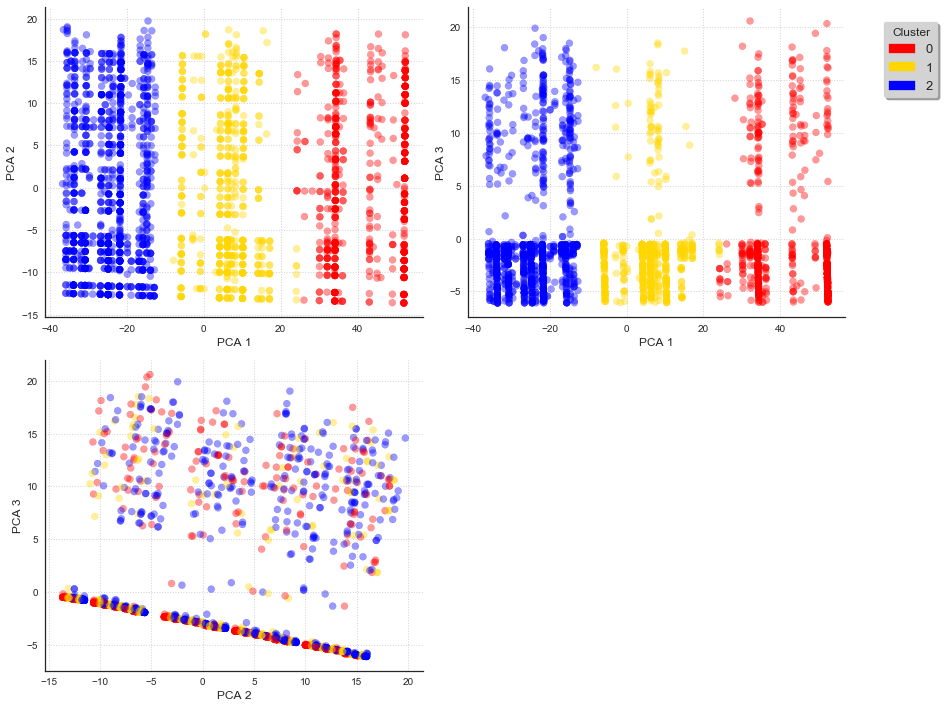

In [18]:
import matplotlib.patches as mpatches

sns.set_style("white")
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2.5})

LABEL_COLOR_MAP = {0:'r', 1:'gold', 2:'b'}
label_color = [LABEL_COLOR_MAP[l] for l in mat['cluster']]

fig = plt.figure(figsize = (12,10))
increment = 0
for ix in range(3):
    for iy in range(ix+1, 3):    
        increment += 1
        ax = fig.add_subplot(2,2,increment)
        ax.scatter(mat[ix], mat[iy], c= label_color, alpha=0.4) 
        plt.ylabel('PCA {}'.format(iy+1), fontsize = 12)
        plt.xlabel('PCA {}'.format(ix+1), fontsize = 12)
        ax.yaxis.grid(color='lightgray', linestyle=':')
        ax.xaxis.grid(color='lightgray', linestyle=':')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        
        if increment == 6: break
    if increment == 6: break
        
#_______________________________________________
# I set the legend: abreviation -> airline name
comp_handler = []
for i in range(3):
    comp_handler.append(mpatches.Patch(color = LABEL_COLOR_MAP[i], label = i))

plt.legend(handles=comp_handler, bbox_to_anchor=(1.1, 0.97), 
           title='Cluster', facecolor = 'lightgrey',
           shadow = True, frameon = True, framealpha = 1,
           fontsize = 13, bbox_transform = plt.gcf().transFigure)

plt.tight_layout()

In [19]:
dff['cluster'] = pd.Series(clusters, index=df.index)
dff['cluster'].value_counts()

2    1274
0     657
1     617
Name: cluster, dtype: int64

In order to have an insight on the quality of the classification, we can represent the silhouette scores of each element of the different clusters. This is the purpose of the next figure which is taken from the sklearn documentation:

In [20]:
def graph_component_silhouette(n_clusters, lim_x, mat_size, sample_silhouette_values, clusters):
    plt.rcParams["patch.force_edgecolor"] = True
    plt.style.use('fivethirtyeight')
    mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
    #____________________________
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(8, 8)
    ax1.set_xlim([lim_x[0], lim_x[1]])
    ax1.set_ylim([0, mat_size + (n_clusters + 1) * 10])
    y_lower = 10
    for i in range(n_clusters):
        #___________________________________________________________________________________
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[clusters == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = cm.spectral(float(i) / n_clusters)        
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,
                           facecolor=color, edgecolor=color, alpha=0.8)
        #____________________________________________________________________
        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.03, y_lower + 0.5 * size_cluster_i, str(i), color = 'red', fontweight = 'bold',
                bbox=dict(facecolor='white', edgecolor='black', boxstyle='round, pad=0.3'))
        #______________________________________
        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  

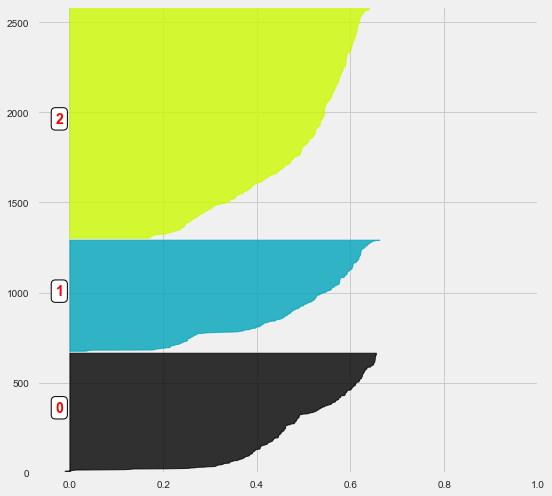

In [21]:
#____________________________________
# define individual silouhette scores
sample_silhouette_values = silhouette_samples(matrix, clusters)
#__________________
# and do the graph
graph_component_silhouette(n_clusters, [-0.07, 1], 2548, sample_silhouette_values, clusters)

In order to ensure that these clusters are truly distinct, I look at their composition. Given the large number of variables of the initial matrix, I first perform a PCA:

In [22]:
pca = PCA()
pca.fit(matrix)
pca_samples = pca.transform(matrix)

and then check for the amount of variance explained by each component:

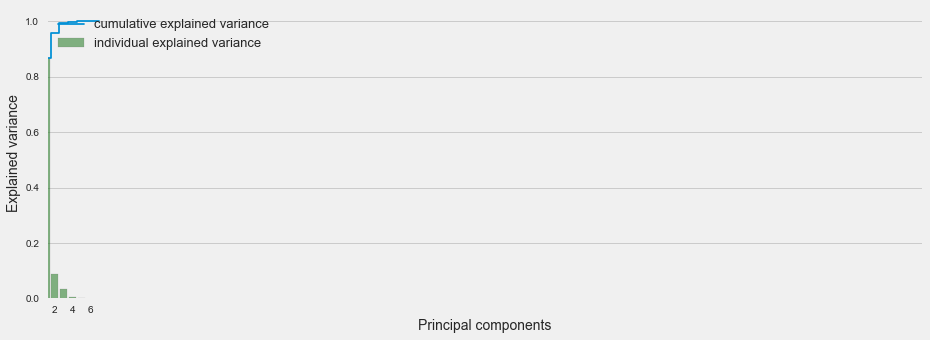

In [23]:
fig, ax = plt.subplots(figsize=(14, 5))
sns.set(font_scale=1)
plt.step(range(matrix.shape[1]), pca.explained_variance_ratio_.cumsum(), where='mid',
         label='cumulative explained variance')
sns.barplot(np.arange(1,matrix.shape[1]+1), pca.explained_variance_ratio_, alpha=0.5, color = 'g',
            label='individual explained variance')
plt.xlim(0, 100)

ax.set_xticklabels([s if int(s.get_text())%2 == 0 else '' for s in ax.get_xticklabels()])

plt.ylabel('Explained variance', fontsize = 14)
plt.xlabel('Principal components', fontsize = 14)
plt.legend(loc='upper left', fontsize = 13);

First, in order to simplify their use, I define a class that allows to interface several of the functionalities common to these different classifiers:

In [24]:
class Class_Fit(object):
    def __init__(self, clf, params=None):
        if params:            
            self.clf = clf(**params)
        else:
            self.clf = clf()

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def grid_search(self, parameters, Kfold):
        self.grid = GridSearchCV(estimator = self.clf, param_grid = parameters, cv = Kfold)
        
    def grid_fit(self, X, Y):
        self.grid.fit(X, Y)
        
    def grid_predict(self, X, Y):
        self.predictions = self.grid.predict(X)
        print("Precision: {:.2f} % ".format(100*metrics.accuracy_score(Y, self.predictions)))

In [25]:
columns = ['transaction_amount', 'transaction_location', 'customer_type', 'dependents', 'weekday', 'day','hour' ]
X = dff[columns]
Y = dff['cluster']

In [26]:

X_train,X_test,Y_train,Y_test = model_selection.train_test_split(X,Y,test_size=0.2)

In [27]:
#SVM classifier
svc = Class_Fit(clf = svm.LinearSVC)
svc.grid_search(parameters = [{'C':np.logspace(-2,2,10)}], Kfold = 5)
svc.grid_fit(X = X_train, Y = Y_train)
svc.grid_predict(X_test, Y_test)

Precision: 97.25 % 


In [28]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    #_________________________________________________
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)
    #_________________________________________________
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    #_________________________________________________
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

*Confusion Matrix*

Confusion matrix, without normalization


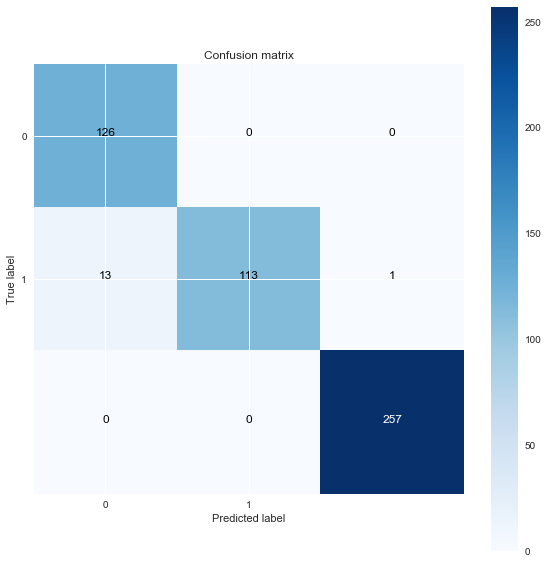

In [29]:
class_names = [i for i in range(2)]
cnf_matrix = confusion_matrix(Y_test, svc.predictions) 
np.set_printoptions(precision=2)
plt.figure(figsize = (8,8))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize = False, title='Confusion matrix')

In [30]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 10)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    return plt

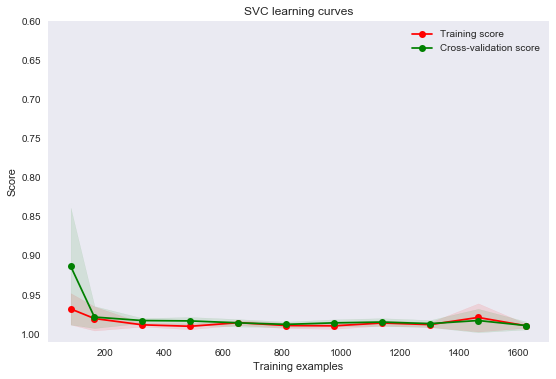

In [31]:


g = plot_learning_curve(svc.grid.best_estimator_,
                        "SVC learning curves", X_train, Y_train, ylim = [1.01, 0.6],
                        cv = 5,  train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5,0.6, 0.7, 0.8, 0.9, 1])



In [32]:
#Logistic Regression Class
lr = Class_Fit(clf = linear_model.LogisticRegression)
lr.grid_search(parameters = [{'C':np.logspace(-2,2,20)}], Kfold = 5)
lr.grid_fit(X = X_train, Y = Y_train)
lr.grid_predict(X_test, Y_test)

Precision: 99.61 % 


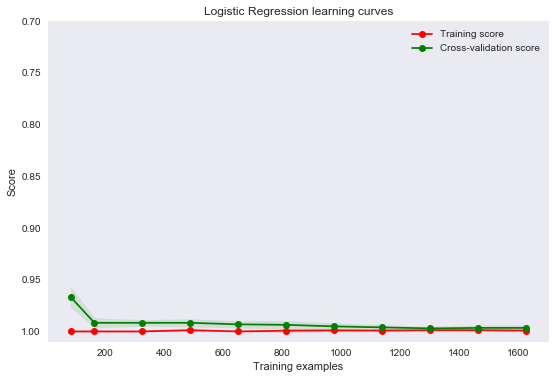

In [33]:
g = plot_learning_curve(lr.grid.best_estimator_, "Logistic Regression learning curves", X_train, Y_train,
                        ylim = [1.01, 0.7], cv = 5, 
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

In [34]:
#K-nearest neighbour

knn = Class_Fit(clf = neighbors.KNeighborsClassifier)
knn.grid_search(parameters = [{'n_neighbors': np.arange(1,50,1)}], Kfold = 5)
knn.grid_fit(X = X_train, Y = Y_train)
knn.grid_predict(X_test, Y_test)



Precision: 100.00 % 


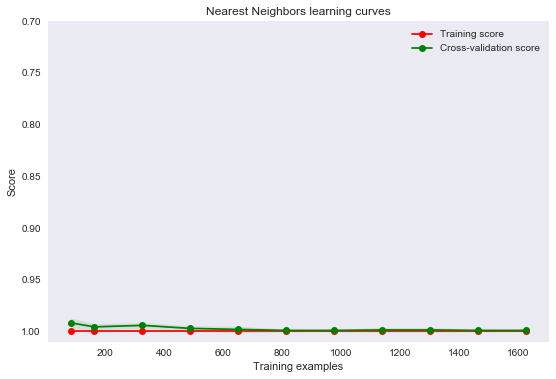

In [35]:
g = plot_learning_curve(knn.grid.best_estimator_, "Nearest Neighbors learning curves", X_train, Y_train,
                        ylim = [1.01, 0.7], cv = 5, 
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

In [36]:
#Decision Trees

tr = Class_Fit(clf = tree.DecisionTreeClassifier)
tr.grid_search(parameters = [{'criterion' : ['entropy', 'gini'], 'max_features' :['sqrt', 'log2']}], Kfold = 5)
tr.grid_fit(X = X_train, Y = Y_train)
tr.grid_predict(X_test, Y_test)



Precision: 100.00 % 


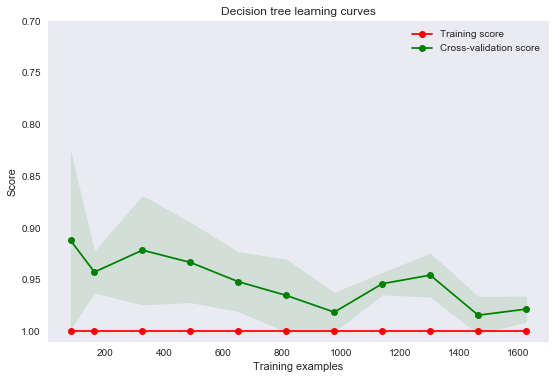

In [37]:


g = plot_learning_curve(tr.grid.best_estimator_, "Decision tree learning curves", X_train, Y_train,
                        ylim = [1.01, 0.7], cv = 5, 
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])



In [38]:
#Random Forest
rf = Class_Fit(clf = ensemble.RandomForestClassifier)
param_grid = {'criterion' : ['entropy', 'gini'], 'n_estimators' : [20, 40, 60, 80, 100],
               'max_features' :['sqrt', 'log2']}
rf.grid_search(parameters = param_grid, Kfold = 5)
rf.grid_fit(X = X_train, Y = Y_train)
rf.grid_predict(X_test, Y_test)



Precision: 99.80 % 


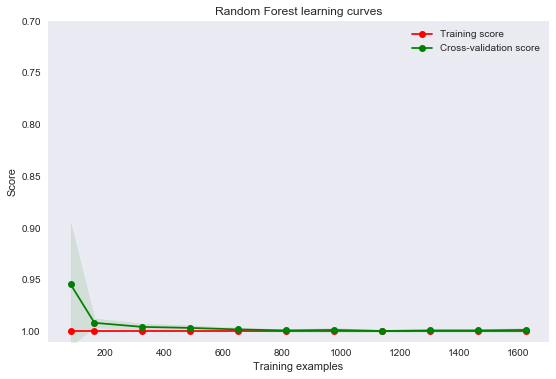

In [39]:
g = plot_learning_curve(rf.grid.best_estimator_, "Random Forest learning curves", X_train, Y_train,
                        ylim = [1.01, 0.7], cv = 5, 
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])


In [40]:
#Adaboost
ada = Class_Fit(clf = AdaBoostClassifier)
param_grid = {'n_estimators' : [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]}
ada.grid_search(parameters = param_grid, Kfold = 5)
ada.grid_fit(X = X_train, Y = Y_train)
ada.grid_predict(X_test, Y_test)

Precision: 100.00 % 


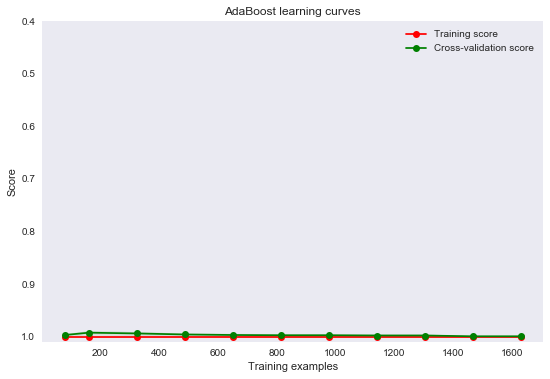

In [41]:


g = plot_learning_curve(ada.grid.best_estimator_, "AdaBoost learning curves", X_train, Y_train,
                        ylim = [1.01, 0.4], cv = 5, 
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])



In [42]:
#Gradient Boosting 
gb = Class_Fit(clf = ensemble.GradientBoostingClassifier)
param_grid = {'n_estimators' : [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]}
gb.grid_search(parameters = param_grid, Kfold = 5)
gb.grid_fit(X = X_train, Y = Y_train)
gb.grid_predict(X_test, Y_test)



Precision: 100.00 % 


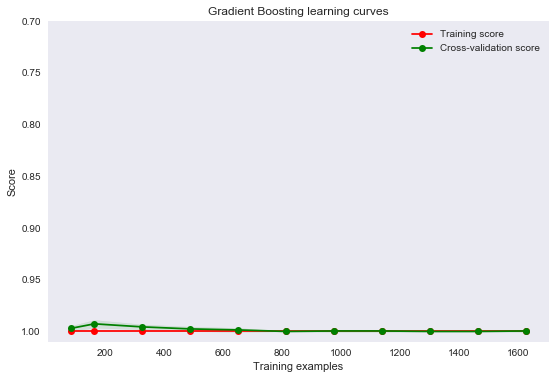

In [43]:
g = plot_learning_curve(gb.grid.best_estimator_, "Gradient Boosting learning curves", X_train, Y_train,
                        ylim = [1.01, 0.7], cv = 5, 
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

**Conclusion:**
Most of the models overfitted the data. Logistic regression, support vector machine and Random forest generalized the model well.
I would prefer Support Vector Machine algorithm for the classication and prediction. But as said eariler models overfitted the data, we need more data to generalize and select best prediction algorithm.
If the regular classifier were not performing well we might have to go with the voting classifier to make better prediction but in this using gradient boosting, adaboost , voting classifier would be overkill for the problem.